 ### 셀 1: 환경 설정 및 라이브러리 설치

In [ ]:
# 이 셀은 필요한 Python 라이브러리를 설치하고, 변경사항을 적용하기 위해 런타임을 재시작합니다.

# 필요한 라이브러리 설치
!pip install transformers==4.40.1
!pip install torchaudio==2.1.2
!pip install librosa==0.10.1
!pip install soundfile==0.12.1
!pip install datasets==2.20.0
!pip install scikit-learn==1.4.2 # 안정적인 버전으로 변경
!pip install numpy==1.26.4 # 안정적인 버전으로 변경
!pip install xgboost==2.0.3

# 런타임 재시작 (설치된 패키지 적용을 위함)
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 110.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.0
    Uninstalling transformers-4.54.0:
      Successfully uninstalled transformers-4.54.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.2
    Uninstalling xgboost-3.0.2:
      Successfully uninstalled xgboost-3.0.2


### 셀 2: 구글 드라이브 마운트 및 라이브러리 임포트

In [1]:
# 런타임 재시작 후, 이 셀을 다시 실행하여 필요한 라이브러리를 임포트하고 구글 드라이브에 연결합니다.

# 필요한 라이브러리 임포트
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa
import soundfile as sf
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split # 데이터 분할을 위해 추가
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from google.colab import drive

# 구글 드라이브 마운트
drive.mount('/content/gdrive')


Mounted at /content/gdrive


 ### 셀 3: 설정값 및 데이터 경로 함수 정의

In [2]:
# 모델 훈련에 필요한 전역 변수를 설정하고, 오디오 파일 경로를 수집하는 함수를 정의합니다.

# 설정값
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

DATASET_ROOT = "/content/gdrive/My Drive/DATASET_ko"
TEST_FILE_PATH = "/content/gdrive/My Drive/test_results.txt"
BATCH_SIZE = 16
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5
# 스펙트로그램의 고정된 길이를 설정하여 패딩/자르기를 수행합니다.
MAX_SPEC_LENGTH = 256

def collect_all_data(data_dir):
    """
    지정된 디렉토리의 모든 오디오 파일 경로와 레이블을 수집합니다.
    (train, validation 폴더가 없는 구조에 맞게 수정됨)
    """
    paths = []
    labels = []
    normal_path = os.path.join(data_dir, "Normal")
    dementia_path = os.path.join(data_dir, "Dementia")

    print(f"Checking for Normal data in: {normal_path}")
    if os.path.exists(normal_path):
        for file_name in os.listdir(normal_path):
            if file_name.endswith('.wav'):
                paths.append(os.path.join(normal_path, file_name))
                labels.append(0)

    print(f"Checking for Dementia data in: {dementia_path}")
    if os.path.exists(dementia_path):
        for file_name in os.listdir(dementia_path):
            if file_name.endswith('.wav'):
                paths.append(os.path.join(dementia_path, file_name))
                labels.append(1)

    print(f"Found {len(paths)} files in {data_dir}")
    return paths, labels

def get_test_data_paths(data_dir):
    """
    테스트 폴더에서 오디오 파일 경로를 수집합니다.
    """
    paths = []
    test_path = os.path.join(data_dir, "test")
    if os.path.exists(test_path):
        for file_name in os.listdir(test_path):
            if file_name.endswith('.wav'):
                paths.append(os.path.join(test_path, file_name))

    print(f"Found {len(paths)} files in {test_path}")
    return paths

# 전체 데이터 수집 및 훈련/검증 데이터로 분할
all_paths, all_labels = collect_all_data(DATASET_ROOT)
if len(all_paths) > 0:
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        all_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
    )
    print(f"Split data: {len(train_paths)} for training, {len(val_paths)} for validation.")
else:
    train_paths, val_paths, train_labels, val_labels = [], [], [], []
    print("Warning: No data found to perform train-validation split.")

test_paths = get_test_data_paths(DATASET_ROOT)


Using device: cuda
Checking for Normal data in: /content/gdrive/My Drive/DATASET_ko/Normal
Checking for Dementia data in: /content/gdrive/My Drive/DATASET_ko/Dementia
Found 2484 files in /content/gdrive/My Drive/DATASET_ko
Split data: 1987 for training, 497 for validation.
Found 515 files in /content/gdrive/My Drive/DATASET_ko/test


 ### 셀 4: 데이터셋 클래스 정의 (CNN, ViT용)

In [3]:
# 오디오 파일을 멜 스펙트로그램으로 변환하여 훈련에 사용될 PyTorch 데이터셋 클래스를 정의합니다.

class AudioDataset(Dataset):
    """오디오 파일을 멜 스펙트로그램으로 변환하여 모델 입력으로 사용합니다."""
    def __init__(self, file_paths, labels, feature_extractor=None, max_length=MAX_SPEC_LENGTH):
        self.file_paths = file_paths
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.max_length = max_length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        audio, sr = librosa.load(file_path, sr=16000)

        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram)

        # 멜 스펙트로그램 길이를 고정
        if mel_spectrogram.shape[1] > self.max_length:
            mel_spectrogram = mel_spectrogram[:, :self.max_length]
        else:
            padding_width = self.max_length - mel_spectrogram.shape[1]
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, padding_width)), mode='constant')

       # ViT 입력 형식에 맞게 3채널로 변환
        if self.feature_extractor:
            mel_spectrogram_3channel = np.stack([mel_spectrogram, mel_spectrogram, mel_spectrogram], axis=-1)

            # === 수정 시작 지점 ===
            # ViT 모델에 입력하기 전에 멜 스펙트로그램을 정규화합니다.
            # 정규화는 멜 스펙트로그램의 픽셀 값 범위를 [0, 1]로 조정합니다.
            # 이 과정은 ViTFeatureExtractor의 internal normalization과 호환됩니다.
            # min-max 정규화
            min_val = np.min(mel_spectrogram_3channel)
            max_val = np.max(mel_spectrogram_3channel)
            mel_spectrogram_normalized = (mel_spectrogram_3channel - min_val) / (max_val - min_val)
            mel_spectrogram_normalized = np.array(mel_spectrogram_normalized * 255, dtype=np.uint8)

            inputs = self.feature_extractor(images=mel_spectrogram_normalized, return_tensors="pt")
            # === 수정 끝 지점 ===

            inputs = {k: v.squeeze(0) for k, v in inputs.items()}
            inputs['labels'] = torch.tensor(label, dtype=torch.long)
            return inputs


        # CNN 입력 형식 (단일 채널)
        else:
            mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0)
            return mel_spectrogram, torch.tensor(label, dtype=torch.long)

### 셀 4-1: 멜 스펙트로그램 이미지 저장 (선택 사항)

In [4]:
# 이 셀을 실행하면 훈련 데이터셋의 멜 스펙트로그램 이미지 일부를 `mel_spectrogram_images` 폴더에 저장합니다.
# **모델 훈련에는 필요하지 않은 선택적 셀입니다.**

def save_mel_spectrogram_as_image(spectrogram, file_path, title="Mel Spectrogram"):
    """
    멜 스펙트로그램을 이미지 파일로 저장합니다.
    """
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, y_axis='mel', x_axis='time')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()

# 이미지를 저장할 폴더 생성
image_save_dir = "/content/gdrive/My Drive/mel_spectrogram_images"
os.makedirs(image_save_dir, exist_ok=True)
print(f"Saving sample images to: {image_save_dir}")

# 훈련 데이터셋에서 처음 5개 샘플의 스펙트로그램을 이미지로 저장
if len(train_paths) > 0:
    sample_dataset = AudioDataset(train_paths[:5], train_labels[:5])
    for i in range(len(sample_dataset)):
        spec, label = sample_dataset[i]
        spec_np = spec.squeeze().numpy()
        label_text = "Dementia" if label.item() == 1 else "Normal"
        file_name = f"sample_{i}_{label_text}.png"
        file_path = os.path.join(image_save_dir, file_name)
        save_mel_spectrogram_as_image(spec_np, file_path, title=f"Sample {i} - {label_text}")
    print("5 sample images saved.")
else:
    print("No training data found, skipping image saving.")


Saving sample images to: /content/gdrive/My Drive/mel_spectrogram_images
5 sample images saved.


 # 셀 5: CNN 모델 정의

In [26]:
# SimpleCNN 클래스 정의
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(p=0.25),  # 드롭아웃 레이어 추가
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(p=0.25)  # 드롭아웃 레이어 추가
        )
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(64 * 32 * 64, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),  # 드롭아웃 레이어 추가
            torch.nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np

# 데이터 증강 클래스 정의
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.01):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # 텐서에 가우시안 노이즈 추가
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

# AudioDataset 클래스 정의
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, feature_extractor=None, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.transform = transform
        self.max_length = 256 # MAX_SPEC_LENGTH 변수를 가정

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        audio, sr = librosa.load(file_path, sr=16000)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram)

        if mel_spectrogram.shape[1] > self.max_length:
            mel_spectrogram = mel_spectrogram[:, :self.max_length]
        else:
            padding_width = self.max_length - mel_spectrogram.shape[1]
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, padding_width)), mode='constant')

        if self.feature_extractor:
            mel_spectrogram_3channel = np.stack([mel_spectrogram, mel_spectrogram, mel_spectrogram], axis=-1)
            min_val = np.min(mel_spectrogram_3channel)
            max_val = np.max(mel_spectrogram_3channel)
            mel_spectrogram_normalized = (mel_spectrogram_3channel - min_val) / (max_val - min_val)
            mel_spectrogram_normalized = np.array(mel_spectrogram_normalized * 255, dtype=np.uint8)
            inputs = self.feature_extractor(images=mel_spectrogram_normalized, return_tensors="pt")

            if self.transform:
                for key in inputs.keys():
                    inputs[key] = self.transform(inputs[key])

            return {k: v.squeeze(0) for k, v in inputs.items()}, torch.tensor(label, dtype=torch.long)

        else: # CNN or RF
            mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0)

            if self.transform:
                mel_spectrogram = self.transform(mel_spectrogram)

            return mel_spectrogram, torch.tensor(label, dtype=torch.long)

In [28]:
import torch
import torch.nn as nn
from transformers import ViTModel

class ViTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.dropout = nn.Dropout(p=0.25)  # 드롭아웃 레이어 추가
        self.fc = nn.Linear(self.vit.config.hidden_size, 2)

    def forward(self, x):
        outputs = self.vit(pixel_values=x)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)  # 드롭아웃 적용
        return self.fc(pooled_output)

In [29]:
# train_model 함수 정의
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4):
    criterion = torch.nn.CrossEntropyLoss()
    # Adam 옵티마이저에 weight_decay 매개변수 추가
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    best_accuracy = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            # ViT 모델인 경우 inputs가 딕셔너리 형태
            if isinstance(inputs, dict):
                inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
                labels = labels.to(DEVICE)
                optimizer.zero_grad()
                outputs = model(**inputs)
                loss = criterion(outputs, labels)
            else: # CNN 모델
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

        # 검증 단계
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                if isinstance(inputs, dict):
                    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
                    labels = labels.to(DEVICE)
                    outputs = model(**inputs)
                else:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)
                    outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {accuracy:.2f}%")

        if accuracy > best_accuracy:
            best_accuracy = accuracy

    return best_accuracy


#셀 6: 모델 훈련 및 평가 함수

In [30]:
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

def train_and_evaluate(model, train_dataloader, val_dataloader, device, model_type):
    # BCEWithLogitsLoss 대신 CrossEntropyLoss를 사용하여 오류 해결
    criterion = nn.CrossEntropyLoss()

    # ViT 모델인 경우 AdamW, 그 외는 Adam
    if model_type == "ViT":
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
    else: # CNN, RandomForest
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    NUM_EPOCHS = 10

    # 훈련
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
            if model_type == "ViT":
                inputs, labels = batch
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(**inputs)
                loss = criterion(outputs.logits, labels)
            else: # CNN
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {running_loss/len(train_dataloader):.4f}")

    # 평가
    model.eval()
    all_labels = []
    all_preds_proba = []
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluating"):
            if model_type == "ViT":
                inputs, labels = batch
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)
                outputs = model(**inputs)

                # CrossEntropyLoss의 출력은 softmax를 거쳐야 확률로 해석 가능
                probs = torch.softmax(outputs.logits, dim=1)
                preds = torch.argmax(probs, dim=1)
            else:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)

                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds_proba.extend(probs.cpu().numpy()[:, 1])
            all_preds.extend(preds.cpu().numpy())

    # 평가 지표 계산
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_preds_proba)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return all_labels, all_preds, all_preds_proba

#  셀 7: 성능 시각화 함수

In [31]:
# 모델의 성능을 혼동 행렬과 ROC 곡선으로 시각화하고, 성능 지표를 반환하는 함수를 정의합니다.

def plot_results(y_true, y_pred, y_prob, model_name):
    """
    분류 결과를 시각화하고 성능 지표를 반환합니다.
    """
    print(f"\n--- {model_name} Results ---")
    report = classification_report(y_true, y_pred, output_dict=True)
    auc = roc_auc_score(y_true, y_prob[:, 1])

    # 혼동 행렬 시각화
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Normal", "Dementia"],
                yticklabels=["Normal", "Dementia"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ROC 곡선 시각화
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return report, auc

  셀 8: 모델별 훈련 및 평가 실행

In [ ]:
# 이 셀은 CNN, ViT, RandomForest 모델을 각각 초기화하고, 훈련 및 평가를 수행합니다.

# CNN 모델
print("Initializing CNN Model...")
if not train_paths or not val_paths:
    print("WARNING: Training or validation data not found. Please check your Google Drive folder structure.")
    cnn_true, cnn_preds, cnn_preds_proba = np.array([]), np.array([]), np.array([[],[]]).T
else:
    cnn_model = SimpleCNN().to(DEVICE)
    cnn_train_dataset = AudioDataset(train_paths, train_labels)
    cnn_val_dataset = AudioDataset(val_paths, val_labels)
    cnn_train_dataloader = DataLoader(cnn_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    cnn_val_dataloader = DataLoader(cnn_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    cnn_true, cnn_preds, cnn_preds_proba = train_and_evaluate(cnn_model, cnn_train_dataloader, cnn_val_dataloader, DEVICE, "CNN")

# ViT 모델
print("\nInitializing ViT Model...")
if not train_paths or not val_paths:
    print("WARNING: Training or validation data not found. Please check your Google Drive folder structure.")
    vit_true, vit_preds, vit_preds_proba = np.array([]), np.array([]), np.array([[],[]]).T
else:
    model_name = "google/vit-base-patch16-224"
    feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
    vit_model = ViTForImageClassification.from_pretrained(model_name,
                                                          num_labels=2,
                                                          ignore_mismatched_sizes=True)
    vit_model.to(DEVICE)
    vit_train_dataset = AudioDataset(train_paths, train_labels, feature_extractor)
    vit_val_dataset = AudioDataset(val_paths, val_labels, feature_extractor)
    vit_train_dataloader = DataLoader(vit_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    vit_val_dataloader = DataLoader(vit_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    vit_true, vit_preds, vit_preds_proba = train_and_evaluate(vit_model, vit_train_dataloader, vit_val_dataloader, DEVICE, "ViT")

# RandomForest 모델
print("\nInitializing RandomForest Model...")
if not train_paths or not val_paths:
    print("WARNING: Training or validation data not found. Please check your Google Drive folder structure.")
    rf_true, rf_preds, rf_preds_proba = np.array([]), np.array([]), np.array([[],[]]).T
else:
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_train_dataset = AudioDataset(train_paths, train_labels)
    rf_val_dataset = AudioDataset(val_paths, val_labels)
    rf_train_dataloader = DataLoader(rf_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    rf_val_dataloader = DataLoader(rf_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    rf_true, rf_preds, rf_preds_proba = train_and_evaluate(rf_model, rf_train_dataloader, rf_val_dataloader, "cpu", "RandomForest")


Initializing CNN Model...


Epoch 1/10:  85%|████████▍ | 106/125 [00:28<00:04,  3.82it/s]

# 셀 9: 성능 지표 수집 및 비교


--- CNN Results ---


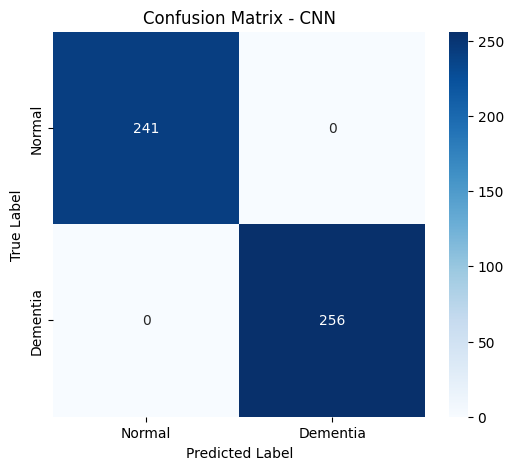

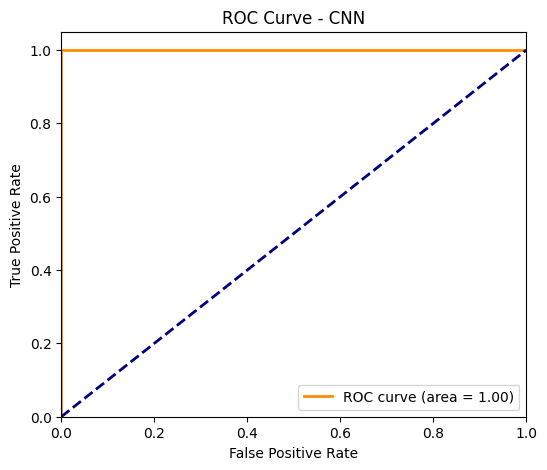


--- ViT Results ---


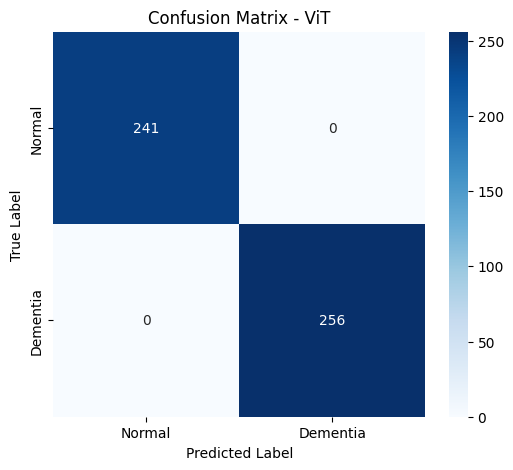

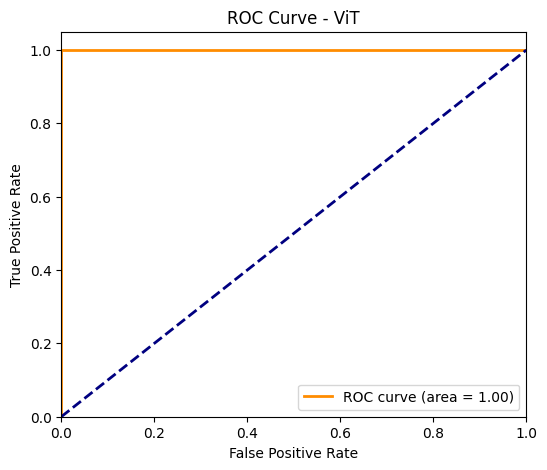


--- RandomForest Results ---


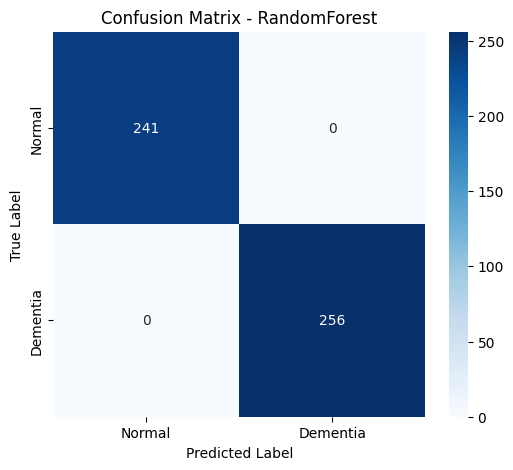

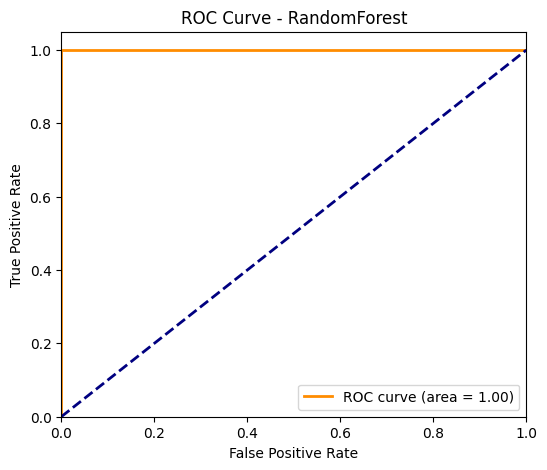


--- Model Performance Comparison ---


,Accuracy,Precision,Recall,F1-Score,AUC
Model,,,,,
CNN,1.0,1.0,1.0,1.0,1.0
ViT,1.0,1.0,1.0,1.0,1.0
RandomForest,1.0,1.0,1.0,1.0,1.0


In [9]:
# 훈련된 각 모델의 성능 지표를 수집하고, 데이터프레임으로 정리하여 비교합니다.

# 데이터가 있을 경우에만 성능 평가 실행
if len(cnn_true) > 0:
    cnn_report, cnn_auc = plot_results(cnn_true, cnn_preds, cnn_preds_proba, "CNN")
    vit_report, vit_auc = plot_results(vit_true, vit_preds, vit_preds_proba, "ViT")
    rf_report, rf_auc = plot_results(rf_true, rf_preds, rf_preds_proba, "RandomForest")

    # 성능 비교 표 생성 및 출력
    results_df = pd.DataFrame({
        'Model': ['CNN', 'ViT', 'RandomForest'],
        'Accuracy': [cnn_report['accuracy'], vit_report['accuracy'], rf_report['accuracy']],
        'Precision': [cnn_report['weighted avg']['precision'], vit_report['weighted avg']['precision'], rf_report['weighted avg']['precision']],
        'Recall': [cnn_report['weighted avg']['recall'], vit_report['weighted avg']['recall'], rf_report['weighted avg']['recall']],
        'F1-Score': [cnn_report['weighted avg']['f1-score'], vit_report['weighted avg']['f1-score'], rf_report['weighted avg']['f1-score']],
        'AUC': [cnn_auc, vit_auc, rf_auc]
    }).set_index('Model')

    print("\n--- Model Performance Comparison ---")
    display(results_df)

# 셀 10: 테스트 데이터 예측 및 결과 저장

In [11]:
# 가장 성능이 좋은 모델을 선택하고, `test` 폴더의 오디오 파일을 사용하여 예측을 수행한 뒤, 결과를 `test_results.txt`에 저장합니다.

print("\n--- Test Predictions ---")
test_ids = []
final_test_preds = []

# 데이터가 있을 경우에만 예측 실행
if len(test_paths) > 0 and 'results_df' in locals():
    # 최적 모델 (예: AUC가 가장 높은 모델) 선택
    best_model_name = results_df['AUC'].idxmax()
    print(f"Best performing model based on AUC is: {best_model_name}")

    if best_model_name == "ViT":
        test_model = vit_model
        test_feature_extractor = feature_extractor
    elif best_model_name == "CNN":
        test_model = cnn_model
        test_feature_extractor = None
    else:  # RandomForest
        test_model = rf_model
        test_feature_extractor = None

    # 테스트 데이터셋 클래스 (레이블 없음)
    class TestAudioDataset(Dataset):
        def __init__(self, file_paths, feature_extractor=None, max_length=MAX_SPEC_LENGTH):
            self.file_paths = file_paths
            self.feature_extractor = feature_extractor
            self.max_length = max_length

        def __len__(self):
            return len(self.file_paths)

        def __getitem__(self, idx):
            file_path = self.file_paths[idx]
            audio, sr = librosa.load(file_path, sr=16000)
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram)

            # --- 수정된 코드: 멜 스펙트로그램 길이를 고정 ---
            if mel_spectrogram.shape[1] > self.max_length:
                mel_spectrogram = mel_spectrogram[:, :self.max_length]
            else:
                padding_width = self.max_length - mel_spectrogram.shape[1]
                mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, padding_width)), mode='constant')
            # -----------------------------------------------

            if self.feature_extractor: # ViT 모델
                mel_spectrogram_3channel = np.stack([mel_spectrogram, mel_spectrogram, mel_spectrogram], axis=-1)

                # ViT 모델 입력 전 정규화
                min_val = np.min(mel_spectrogram_3channel)
                max_val = np.max(mel_spectrogram_3channel)
                mel_spectrogram_normalized = (mel_spectrogram_3channel - min_val) / (max_val - min_val)
                mel_spectrogram_normalized = np.array(mel_spectrogram_normalized * 255, dtype=np.uint8)

                inputs = self.feature_extractor(images=mel_spectrogram_normalized, return_tensors="pt")
                return {k: v.squeeze(0) for k, v in inputs.items()}, os.path.basename(file_path)
            else:  # CNN or RF
                # CNN 모델을 위해 채널 차원 추가 (unsqueeze(0))
                # RF 모델을 위해서는 reshape()에서 처리되므로 차원 유지 가능
                mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0)
                return mel_spectrogram, os.path.basename(file_path)

    test_dataset = TestAudioDataset(test_paths, test_feature_extractor)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 테스트 예측 수행
    if best_model_name in ["ViT", "CNN"]:
        test_model.eval()
        with torch.no_grad():
            for inputs, file_names in tqdm(test_dataloader, desc="Predicting on test data"):
                test_ids.extend([f.split('.')[0] for f in file_names])
                if best_model_name == "ViT":
                    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
                    outputs = test_model(**inputs)
                    logits = outputs.logits
                else:  # CNN
                    inputs = inputs.to(DEVICE)
                    outputs = test_model(inputs)
                    logits = outputs

                predictions = torch.argmax(logits, dim=-1)
                final_test_preds.extend(predictions.cpu().numpy())
    else:  # RandomForest
        test_features = []
        for x, file_name in tqdm(test_dataloader, desc="Preparing RF test data"):
            # RandomForest를 위해 1차원 배열로 변환
            test_features.extend(x.reshape(x.shape[0], -1).numpy())
            test_ids.extend([f.split('.')[0] for f in file_name])
        final_test_preds = test_model.predict(test_features)

    # --- 수정된 코드: 예측값을 텍스트 레이블로 변환 ---
    # 0은 'normal', 1은 'dementia'로 매핑합니다.
    label_map = {0: 'normal', 1: 'dementia'}
    final_test_labels = [label_map[pred] for pred in final_test_preds]
    # ----------------------------------------------------

    # test_results.txt 파일 형식에 맞게 결과 저장
    try:
        with open(TEST_FILE_PATH, 'w') as f:
            f.write("ID;Prediction\n")
            for i, pred in enumerate(final_test_labels):
                f.write(f"{test_ids[i]};{pred}\n")

        print(f"Predictions saved to {TEST_FILE_PATH}")
    except Exception as e:
        print(f"Error saving predictions: {e}")
else:
    print("WARNING: Test data not found or no models were trained. Skipping final prediction step.")


--- Test Predictions ---
Best performing model based on AUC is: CNN


Predicting on test data: 100%|██████████| 33/33 [06:00<00:00, 10.93s/it]


Predictions saved to /content/gdrive/My Drive/test_results.txt
